In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator, PchipInterpolator, LinearNDInterpolator
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import multiprocessing
from tqdm.auto import tqdm
from pdet import MZQbin, alphaBayesCI_map, RateRatioBayesCI_map, _bin_initializer_worker

/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [2]:
minf, msup = 8, 13
# zw = 0.01 # Width of redshift bins
zw = 0.05
q = 0.5 # # q = m2 / m1, with m2 <= m1

T_obs = 1

zinf_axis = np.arange(0, 6, zw)
bins_axis = [MZQbin(minf, msup, zinf, zinf + zw, q) for zinf in zinf_axis]
R1_R2_axis = np.arange(0.01, 5, 0.01)

N1_N2_axis = np.arange(0.01, 10, 0.02)

cl = 0.95

In [3]:
# Bin initializer: Computes and saves VT
def bin_initializer(bin_list, T_obs, mcn=100000):
    args = [(i, bin, T_obs, mcn) for i, bin in enumerate(bins_axis)]

    # Use unordered multiprocessing to initialize bins
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = list(tqdm(pool.imap_unordered(_bin_initializer_worker, args), total=len(args),
                            desc='Initilizing bins: computing VT'))
        
    # Reorder and return the results
    for i, bin in results:
        bin_list[i] = bin

    return bin_list

In [4]:
# Initialize the bins before using mapping functions!!
if __name__ == '__main__':
    bin_initializer(bins_axis, T_obs)

Initilizing bins: computing VT:   0%|          | 0/120 [00:00<?, ?it/s]/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resourc

In [5]:
zref = 0.25 # Reference redshift (inferior limit of reference redshift bin)
bin2_ref = MZQbin(minf, msup, zref, zref + zw, q)
N2_ref = 60
bin2_ref.VTmc(T_obs)

np.float64(12234743748.484509)

In [6]:
alpha_CI_map = alphaBayesCI_map(cl, bin2_ref, R1_R2_axis, bins_axis, N2_ref, T_obs)

Computing number of events ratio map:   0%|          | 0/59880 [00:00<?, ?it/s]/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/pdet.py:217: RuntimeWarning: divide by zero encountered in scalar divide
  a = bin2.VT / self.VT
Computing number of events ratio map: 100%|██████████| 59880/59880 [00:24<00:00, 2427.90it/s]


In [7]:
R1_R2_CI_map = RateRatioBayesCI_map(cl, bin2_ref, N1_N2_axis, bins_axis, N2_ref, T_obs)

Computing rate ratio map:   0%|          | 0/60000 [00:00<?, ?it/s]/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/pdet.py:237: RuntimeWarning: divide by zero encountered in scalar divide
  a = bin2.VT / self.VT
/Users/Federico/Documents/Corsi di studio/Università/Tesi/master_thesis/.venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
Computing rate ratio map: 100%|██████████| 60000/60000 [00:24<00:00, 2411.16it/s]


In [8]:
alpha_CI_array = np.zeros((len(R1_R2_axis), len(bins_axis), 3))
alpha_a_array = np.zeros((len(R1_R2_axis), len(bins_axis)))

N1_N2_ref = 2
# 1 if R1_R2_ref is inside confidence interval
Det_map_alpha = np.zeros((len(R1_R2_axis), len(bins_axis)))

# Fill the arrays
for i, _ in enumerate(R1_R2_axis):
    for j, _ in enumerate(bins_axis):
        alpha_CI_array[i, j] = np.copy(alpha_CI_map[i][j][0])
        alpha_a_array[i, j] = alpha_CI_map[i][j][2] # a = bin2_ref.VT / bin.VT
        
        if alpha_CI_map[i][j][0][0] <= N1_N2_ref <= alpha_CI_map[i][j][0][2]:
            Det_map_alpha[i, j] = 1

In [9]:
print(np.min(alpha_CI_array[:, :, 1]), np.max(alpha_CI_array[:, :, 1]))
print(np.min(alpha_a_array), np.max(alpha_a_array))

0.0037825042540002287 17.37723054954249
0.2864059875313736 inf


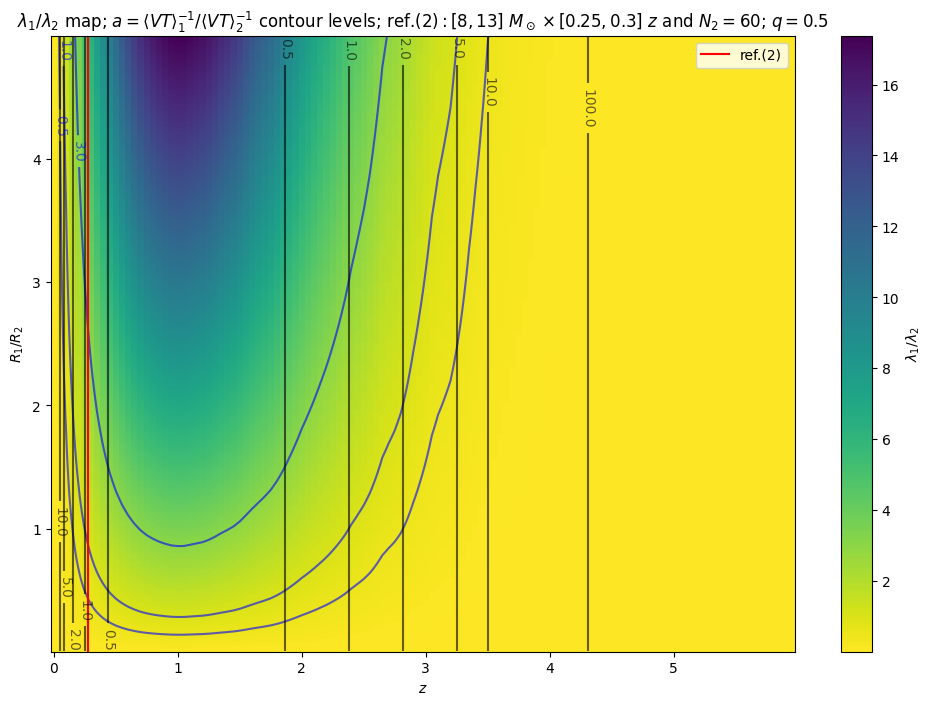

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$\lambda_1 / \lambda_2$ map; $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}}$ contour levels; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$'.format(bin2_ref.minf,
                                                                                                                                                                                                                     bin2_ref.msup,
                                                                                                                                                                                                                     bin2_ref.zinf,
                                                                                                                                                                                                                     np.format_float_positional(bin2_ref.zsup, 3),
                                                                                                                                                                                                                     N2_ref,
                                                                                                                                                                                                                     q))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$R_1 / R_2$')

# lambda_1 / lamba_2 color map
cmap = plt.colormaps['viridis_r']
im = ax.pcolormesh(zinf_axis, R1_R2_axis, alpha_CI_array[:, :, 1],
                   cmap=cmap)
fig.colorbar(im, ax=ax, label=r'$\lambda_1 / \lambda_2$')

# N1/N2 Contour levels
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_CI_array[:, :, 1],
                levels=[0.5, 1, 3], colors='blue', alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red', label='ref.(2)')

ax.legend()

plt.show()

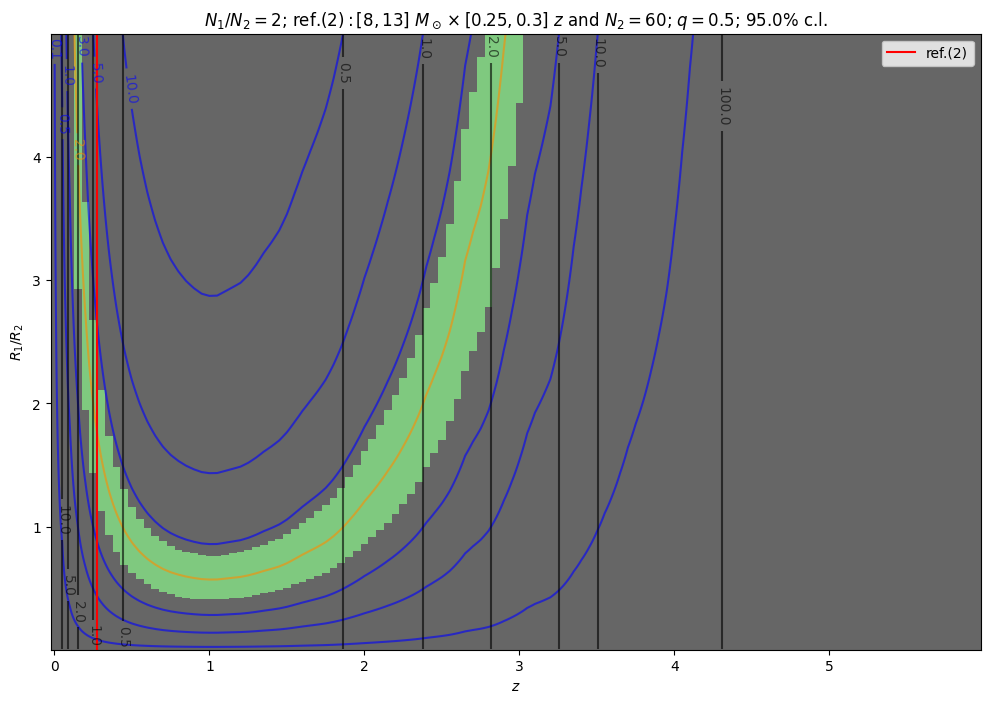

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$N_1 / N_2 = {5}$; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {6}$; {7}% c.l.'.format(bin2_ref.minf,
                                                                                                                       bin2_ref.msup,
                                                                                                                       bin2_ref.zinf,
                                                                                                                       np.format_float_positional(bin2_ref.zsup, 3),
                                                                                                                       N2_ref,
                                                                                                                       N1_N2_ref,
                                                                                                                       q,
                                                                                                                       cl * 100))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$R_1 / R_2$')

# lambda_1 / lamba_2 color map
cmap = plt.colormaps['Accent_r']
im = ax.pcolormesh(zinf_axis, R1_R2_axis, Det_map_alpha,
                   cmap=cmap)

# N1/N2 Contour levels
levels = list(dict.fromkeys(sorted([0.1, 0.5, 1, 3, 5, 10, N1_N2_ref]))) # To avoid duplicates
colors = ['blue'] * (len(levels))
colors[levels.index(N1_N2_ref)] = 'darkorange'
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_CI_array[:, :, 1],
                levels=levels, colors=colors, alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, R1_R2_axis, alpha_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red', label='ref.(2)')

ax.legend()

plt.show()

In [12]:
R1_R2_CI_array = np.zeros((len(N1_N2_axis), len(bins_axis), 3))
R1_R2_a_array = np.zeros((len(N1_N2_axis), len(bins_axis)))

R1_R2_ref = 2
# 1 if R1_R2_ref is inside confidence interval
Det_map_R1_R2 = np.zeros((len(N1_N2_axis), len(bins_axis)))

R1_R2_ref_list = [0.5, 1, 2, 3, 5, 10]
# Linked to R1_R2_ref_list on the first dimension. True if the corresponding R1_R2 value is inside the confidence interval
R1_R2_CI_list_mask = np.zeros((len(R1_R2_ref_list), len(N1_N2_axis), len(bins_axis)), dtype=bool)

# Fill the arrays
for i, _ in enumerate(N1_N2_axis):
    for j, _ in enumerate(bins_axis):
        R1_R2_CI_array[i, j] = np.copy(R1_R2_CI_map[i][j][0])
        R1_R2_a_array[i, j] = R1_R2_CI_map[i][j][2] # a = bin2_ref.VT / bin.VT

        if R1_R2_CI_map[i][j][0][0] <= R1_R2_ref <= R1_R2_CI_map[i][j][0][2]:
            Det_map_R1_R2[i, j] = 1
            
        for k, R1_R2 in enumerate(R1_R2_ref_list):
            if R1_R2_CI_map[i][j][0][0] <= R1_R2 <= R1_R2_CI_map[i][j][0][2]:
                R1_R2_CI_list_mask[k, i, j] = True

# For each value in R1_R2_ref_list, select the N1_N2 vs z curves that represents the associated confidence interval
inf_lvl_alpha = np.zeros((len(R1_R2_ref_list), len(bins_axis)))
sup_lvl_alpha = np.zeros((len(R1_R2_ref_list), len(bins_axis)))

for i in range(len(R1_R2_ref_list)):
    for j in range(len(bins_axis)):
        True_indexes = np.where(R1_R2_CI_list_mask[i, :, j])[0]
        if len(True_indexes) != 0:
            inf_lvl_alpha[i, j] = N1_N2_axis[True_indexes[0]]
            sup_lvl_alpha[i, j] = N1_N2_axis[True_indexes[-1]]

In [13]:
print(np.min(R1_R2_CI_array[:, :, 1]), np.max(R1_R2_CI_array[:, :, 1]))
print(np.min(R1_R2_a_array), np.max(R1_R2_a_array))

0.0037625734188347546 inf
0.2864059875313736 inf


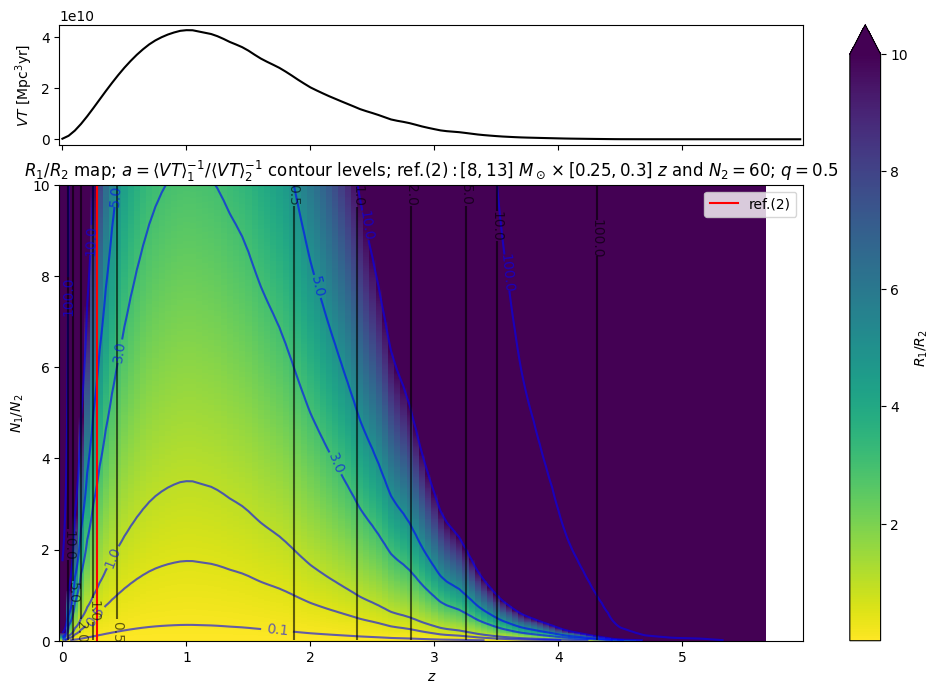

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

divider = make_axes_locatable(ax)

ax_z = divider.append_axes('top', 1.2, pad=0.4, sharex=ax)

ax_z.tick_params(labelbottom=False)

ax.set_title(r'$R_1 / R_2$ map; $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}}$ contour levels; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$'.format(bin2_ref.minf,
                                                                                                                                                                                                                     bin2_ref.msup,
                                                                                                                                                                                                                     bin2_ref.zinf,
                                                                                                                                                                                                                     np.format_float_positional(bin2_ref.zsup, 3),
                                                                                                                                                                                                                     N2_ref,
                                                                                                                                                                                                                     q))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$N_1 / N_2$')

# lambda_1 / lamba_2 color map
cmap = plt.colormaps['viridis_r']
im = ax.pcolormesh(zinf_axis, N1_N2_axis, R1_R2_CI_array[:, :, 1],
                   cmap=cmap, norm=mpl.colors.Normalize(vmin=np.min(R1_R2_CI_array[:, :, 1]), vmax=10))
fig.colorbar(im, ax=ax, label=r'$R_1 / R_2$', extend='max')

# R1/R2 Contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_CI_array[:, :, 1],
                levels=[0.1, 0.5, 1, 3, 5, 10, 100], colors='blue', alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red', label='ref.(2)')

ax_z.set_ylabel(r'$VT\ [\text{Mpc}^3 \text{yr}]$')

ax_z.plot(zinf_axis, [bin.VT for bin in bins_axis], color='black')

ax.legend()

plt.show()

This map tells us what is the merger rate ratio $R_1 / R_2$ when we compare two bins, where one has fixed redshift (and both have fixed mass), as a function of the number of events ratio $N_1 / N_2$ between those two bins.

Vertical lines are $\langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}}$ constants.

$\dfrac{R_1}{R_2} = \dfrac{\langle VT \rangle_2}{\langle VT \rangle_1} \dfrac{N_1}{N_2}$.

The top panel shows $VT$ for each redshift bin on the $z$ axis. At any value of $N_1 / N_2$, for higher values of $VT$ we have smaller values of $R_1 / R_2$, encoding the fact that it is more likely to see events in bins with higher $VT$.

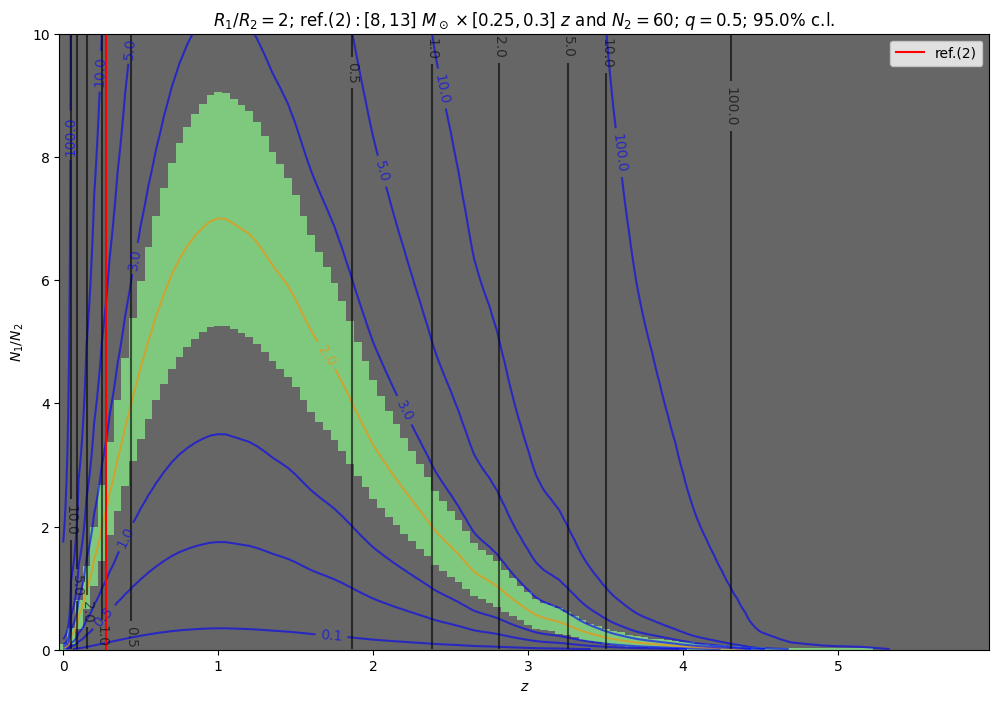

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$R_1 / R_2 = {5}$; $\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {6}$; {7}% c.l.'.format(bin2_ref.minf,
                                                                                                                       bin2_ref.msup,
                                                                                                                       bin2_ref.zinf,
                                                                                                                       np.format_float_positional(bin2_ref.zsup, 3),
                                                                                                                       N2_ref,
                                                                                                                       R1_R2_ref,
                                                                                                                       q,
                                                                                                                       cl * 100))
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$N_1 / N_2$')

# lambda_1 / lamba_2 color map
cmap = plt.colormaps['Accent_r']
im = ax.pcolormesh(zinf_axis, N1_N2_axis, Det_map_R1_R2,
                   cmap=cmap)

# R1/R2 Contour levels
levels = list(dict.fromkeys(sorted([0.1, 0.5, 1, 3, 5, 10, 100, R1_R2_ref]))) # To avoid duplicates
colors = ['blue'] * (len(levels))
colors[levels.index(R1_R2_ref)] = 'darkorange'
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_CI_array[:, :, 1],
                levels=levels, colors=colors, alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red', label='ref.(2)')

ax.legend()

plt.show()

This map colors the bins based on wheter their associated $R_1 / R_2$ distribution includes or not the chosen reference value, within some credibility level.

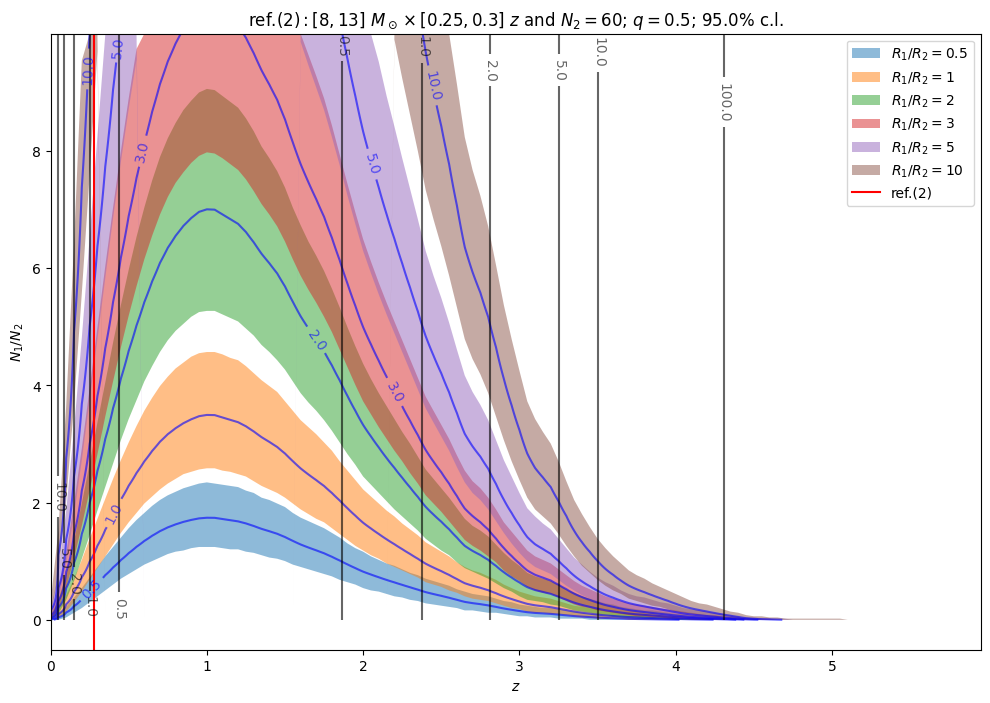

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$\text{{ref.(2)}}: [{0}, {1}]\ M_\odot \times [{2}, {3}]\ z$ and $N_2 = {4}$; $q = {5}$; {6}% c.l.'.format(bin2_ref.minf,
                                                                                                                       bin2_ref.msup,
                                                                                                                       bin2_ref.zinf,
                                                                                                                       np.format_float_positional(bin2_ref.zsup, 3),
                                                                                                                       N2_ref,
                                                                                                                       q,
                                                                                                                       cl * 100))

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$N_1 / N_2$')

# R_1 / R_2 confidence intervals for multiple values of R1_R2_ref and 
for inf, sup, lb in zip(inf_lvl_alpha, sup_lvl_alpha, R1_R2_ref_list):
    ax.fill_between(zinf_axis, inf, sup, alpha=0.5,
                    label=r'$R_1 / R_2 = {0}$'.format(lb))

# R1/R2 Contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_CI_array[:, :, 1],
                levels=R1_R2_ref_list, colors='blue', alpha=0.6)
ax.clabel(cf)

# a contour levels
cf = ax.contour(zinf_axis, N1_N2_axis, R1_R2_a_array,
                levels=[0.5, 1, 2, 5, 10, 100], colors='black', alpha=0.6)
ax.clabel(cf)

# Reference line for the reference bin
ax.axvline((bin2_ref.zinf + bin2_ref.zsup) / 2, color='red', label='ref.(2)')

ax.legend()

plt.show()

In [17]:
interpolated_R1_R2 = RegularGridInterpolator((N1_N2_axis, zinf_axis), R1_R2_CI_array[:, :, 1], bounds_error=False, fill_value=0)
np.median(interpolated_R1_R2(np.vstack((inf_lvl_alpha[3], zinf_axis)).T))

np.float64(2.211863341133407)

In [18]:
zinf_for_interpolant = np.array([bin.zinf for bin in bins_axis])
VT_for_interpolant = np.array([bin.VT for bin in bins_axis])

VT_interpolant = PchipInterpolator(zinf_for_interpolant, VT_for_interpolant, extrapolate=True)

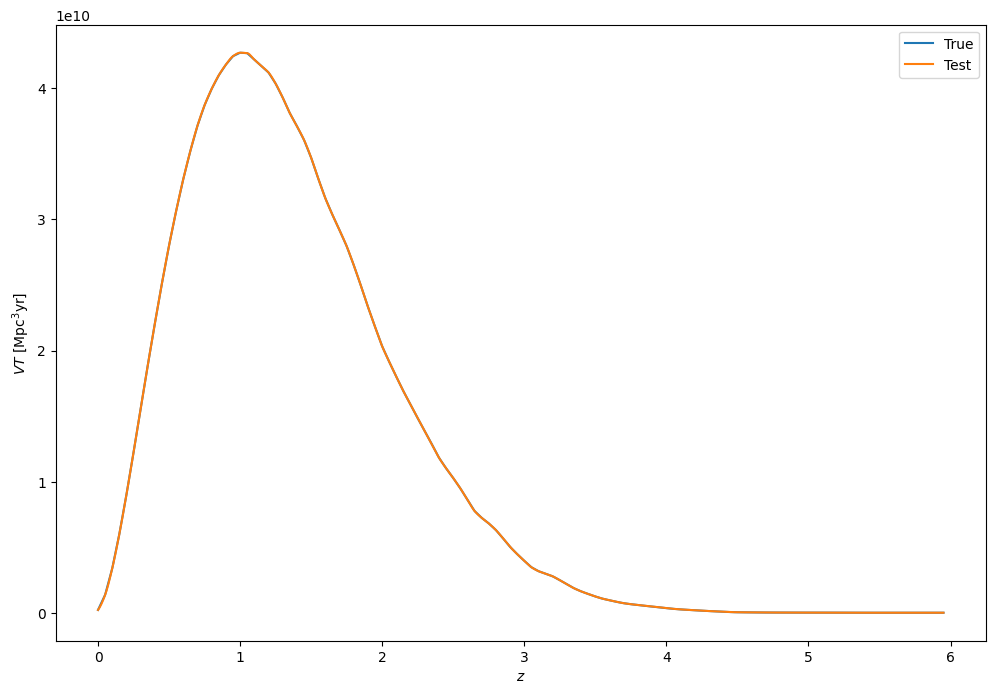

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$VT\ [\mathrm{Mpc^3 yr}]$')

ax.plot(zinf_for_interpolant, VT_for_interpolant, label='True')

z_test = np.linspace(np.min(zinf_for_interpolant), np.max(zinf_for_interpolant), 1000)
VT_test = VT_interpolant(z_test)

ax.plot(z_test, VT_test, label='Test')

ax.legend()

plt.show()

In [20]:
def z_inf_at_VT_fixed_mq(VT_array, VT_interpolant):
    z = [VT_interpolant.solve(VT, extrapolate=False) for VT in VT_array]

    z_peak = 1
    z_sx, z_dx = [], []
    VT_sx, VT_dx = [], []
    for i, (z_arr, VT) in enumerate(zip(z, VT_array)):
        z[i] = np.delete(z_arr, z_arr < 0)
        if len(z[i]) == 1:
            if z[i][0] > z_peak:
                z_dx.append(z[i][0])
                VT_dx.append(VT)
            else:
                z_sx.append(z[i][0])
                VT_sx.append(VT)
        elif len(z[i]) == 2:
            z_sx.append(z[i][0])
            VT_sx.append(VT)
            z_dx.append(z[i][1])
            VT_dx.append(VT)

    return (np.array(z_sx), np.array(VT_sx)), (np.array(z_dx), np.array(VT_dx))

In [21]:
VT_test = np.linspace(np.min(VT_for_interpolant), np.max(VT_for_interpolant), 1000)
(z_sx, VT_sx), (z_dx, VT_dx) = z_inf_at_VT_fixed_mq(VT_test, VT_interpolant)

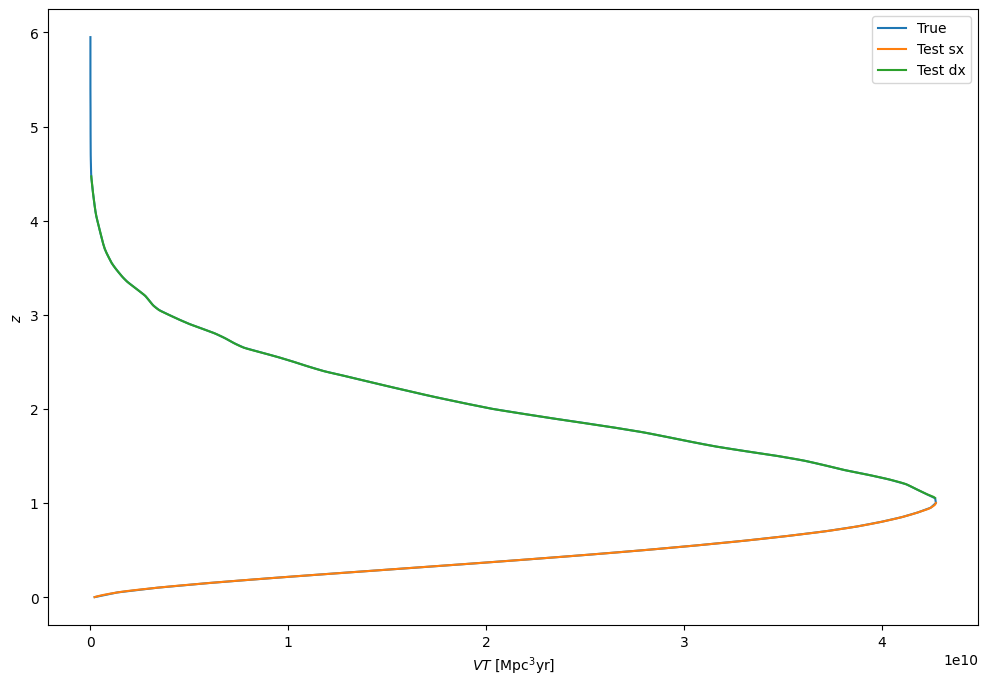

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(VT_for_interpolant, zinf_for_interpolant, label='True')

ax.set_xlabel(r'$VT\ [\mathrm{Mpc^3 yr}]$')
ax.set_ylabel(r'$z$')

for z_grid, VT_grid, lb in zip((z_sx, z_dx), (VT_sx, VT_dx), ('Test sx', 'Test dx')):
    ax.plot(VT_grid, z_grid, label=lb)
    
ax.legend()

plt.show()

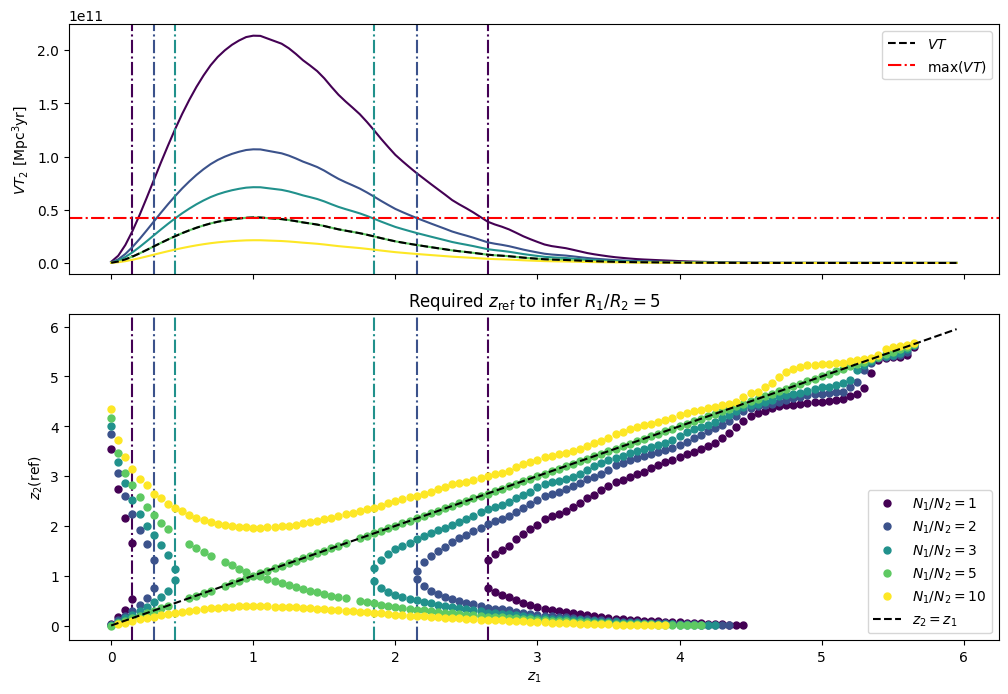

In [23]:
R1_R2 = 5
alpha = [1, 2, 3, 5, 10]
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(alpha)))

VT_1 = VT_for_interpolant
z_1 = zinf_for_interpolant

a = [R1_R2 / _alpha for _alpha in alpha]
VT_2 = [VT_1 * _a for _a in a]
z_2 = [z_inf_at_VT_fixed_mq(VT_grid, VT_interpolant) for VT_grid in VT_2]

fig, ax = plt.subplots(figsize=(12, 8))

divider = make_axes_locatable(ax)

ax_z = divider.append_axes('top', 2.5, pad=0.4, sharex=ax)

ax_z.tick_params(labelbottom=False)

ax.set_title(r'Required $z_\text{{ref}}$ to infer $R_1 / R_2 = {0}$'.format(R1_R2))

ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2(\text{ref})$')

ax_z.set_ylabel(r'$VT_2\ [\text{Mpc}^3 \text{yr}]$')

lines = []
for ((z_sx,  VT_sx), (z_dx, VT_dx)), _VT_2, _alpha, c in zip(z_2, VT_2, alpha, colors):
    mask_sx, mask_dx = [], []
    for _VT_sx in VT_sx:
        mask_sx.append(np.where(_VT_2 == _VT_sx)[0])
    for _VT_dx in VT_dx:
        mask_dx.append(np.where(_VT_2 == _VT_dx)[0])
    
    mask_sx, mask_dx = np.squeeze(np.array(mask_sx)), np.squeeze(np.array(mask_dx))

    for i, (z, mask) in enumerate(zip((z_sx, z_dx), (mask_sx, mask_dx))):
        line = ax.plot(z_1[mask], z, color=c,
                       linestyle='', marker='o', markersize=5,
                       label=r'$N_1 / N_2 = {0}$'.format(_alpha))[0]
        if i == 0:
            lines.append(line)

    ax_z.plot(z_1, _VT_2, color=c)
    
    smaller_indexes = np.where(_VT_2 <= np.max(VT_1))[0]
    smaller_indx = smaller_indexes[0]
    for i in smaller_indexes[1:]:
        if i == smaller_indx + 1:
            smaller_indx = smaller_indx + 1
        else:
            smaller_indx = (smaller_indx, i)
            break
    
    if isinstance(smaller_indx, tuple):
        for _ax in (ax, ax_z):
            for val in smaller_indx:
                _ax.axvline(z_1[val], color=c, linestyle='-.')

ax_z.plot(z_1, VT_1, color='black', linestyle='--', label=r'$VT$')
ax_z.axhline(np.max(VT_1), color='red', linestyle='-.', label=r'$\max(VT)$')

lines.append(ax.plot(z_1, z_1, color='black', linestyle='--', label=r'$z_2 = z_1$')[0])

ax.legend(handles=lines)
ax_z.legend()

plt.show()

This plot tells us what the reference redshift $z_2$ should be assuming a value of $R_1 / R_2$, for different choices of $N_1 / N_2$, as a function of the redshift of the other bin $z_1$. The obtained values rely on a interpolator of the $VT$ vs. $z$ relation, $f$, for a _fixed_ mass bin and mass ratio $q$.

$VT_2 = \dfrac{R_1}{R_2} \dfrac{N_2}{N_1} VT_1$ and $VT = f(z)$. From the interpolator we get $f^{-1}$. Then $z_2 = f^{-1}(VT_2)$.

Depending on the values of $N_1 / N_2$ and $R_1 / R_2$ some redshift intervals are empty. That is due to the fact that the maximum achievable $VT$ is set by the function $f$. So, since $VT_2$ is just a rescaling of $VT_1$, if $VT_2 > VT_1$ there will be some values of $VT_2$ which are not physically achievable with the assumed cosmology and detector network.

In [24]:
# A_for_interpolant = np.concatenate((np.linspace(0.1, 1, 50, endpoint=False), np.linspace(1, 10, 50)))
# alpha_for_interpolant = np.copy(A_for_interpolant)
# z_1_for_interpolant = np.copy(zinf_for_interpolant)

# A, ALPHA, Z1 = np.meshgrid(A_for_interpolant, alpha_for_interpolant, z_1_for_interpolant, indexing='ij')
# VT_RATIO = A / ALPHA
# VT_2 = VT_1 * VT_RATIO

# Z2 = np.full((*VT_2.shape, 2), np.nan)

# with tqdm(total=np.prod(VT_2.shape)) as pbar:
#     for i, vt_2_2d in enumerate(VT_2):
#         for j, vt_2_1d in enumerate(vt_2_2d):
#             for k, vt_2 in enumerate(vt_2_1d):
#                 (z_2_sx, _), (z_2_dx, _) = z_inf_at_VT_fixed_mq(np.array([vt_2]), VT_interpolant)
#                 for l, z_2 in enumerate([z_2_sx, z_2_dx]):
#                     if z_2.shape == (1,):
#                         Z2[i][j][k][l] = z_2[0]
#                 pbar.update(1)

In [25]:
# A_ALPHA_Z1_for_interpolant = np.array([np.ravel(GRID) for GRID in (A, ALPHA, Z1)]).T
# Z2_for_interpolant = np.reshape(Z2, (np.prod(VT_2.shape), 2))

# z_2_interpolant = LinearNDInterpolator(A_ALPHA_Z1_for_interpolant, Z2_for_interpolant)
# np.save("z_ref_interpolant", np.array([z_2_interpolant]))
z_2_interpolant = np.load("z_ref_interpolant.npy", allow_pickle=True)[0]

In [26]:
R1_R2_test = 5
alpha_test = np.linspace(0.1, 10, 50)
colors_test = plt.get_cmap('viridis')(np.linspace(0, 1, len(alpha_test)))
z_1_test = np.linspace(0, 10, 500)
test_grid = np.array([[[R1_R2_test, _alpha, z_1] for z_1 in z_1_test] for _alpha in alpha_test])
z_2_test = z_2_interpolant(test_grid)

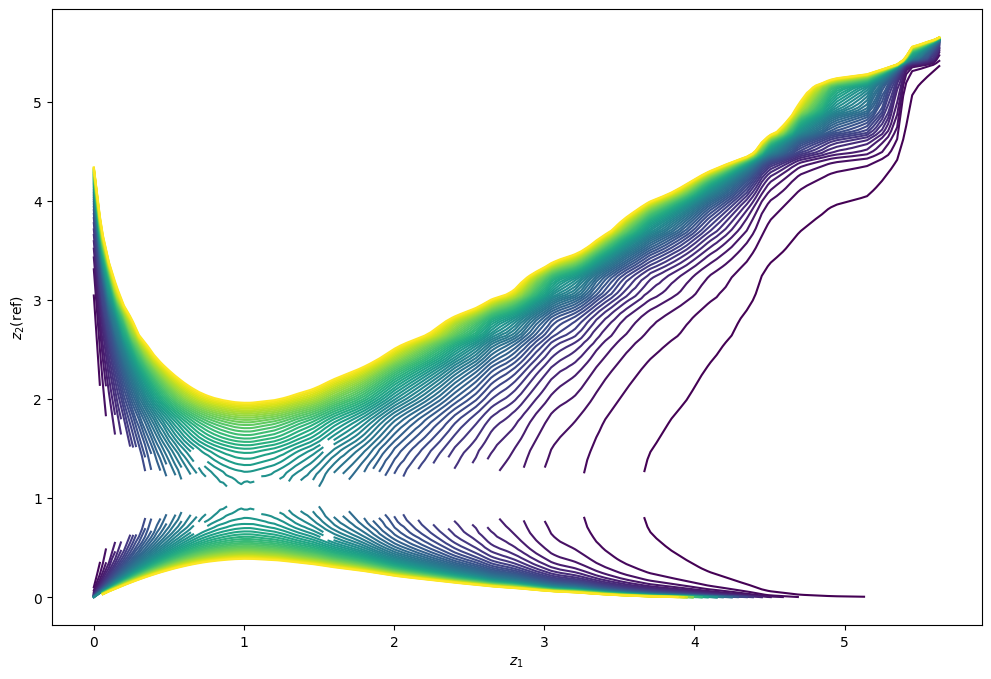

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2(\text{ref})$')

lines = []
for _z_2_test, _alpha, c in zip(z_2_test, alpha_test, colors_test):
    line = ax.plot(z_1_test, _z_2_test, color=c,
                   label=r'$N_1 / N_2 = {0}$'.format(_alpha))[0]
    
    lines.append(line)

# ax.legend(handles=lines)

plt.show()

In [28]:
z2_test_exists_mask = ~np.isnan(z_2_test)
z2_test_alpha_sx_mask = np.full(z2_test_exists_mask[:, :, 0].shape, False)
z2_test_alpha_dx_mask = np.full(z2_test_exists_mask[:, :, 1].shape, False)

for ds, z2_test_alpha_mask in enumerate((z2_test_alpha_sx_mask, z2_test_alpha_dx_mask)):
    for i, vals in enumerate(z2_test_exists_mask[:, :, ds].T):
        first = None
        last = None
        for j, val in enumerate(vals):
            if first is None and val:
                first, last = j, j
            elif val:
                last = j
        if first is not None:
            z2_test_alpha_mask[first, i] = True
            z2_test_alpha_mask[last, i] = True

alpha_sx = test_grid[z2_test_alpha_sx_mask]
alpha_dx = test_grid[z2_test_alpha_dx_mask]

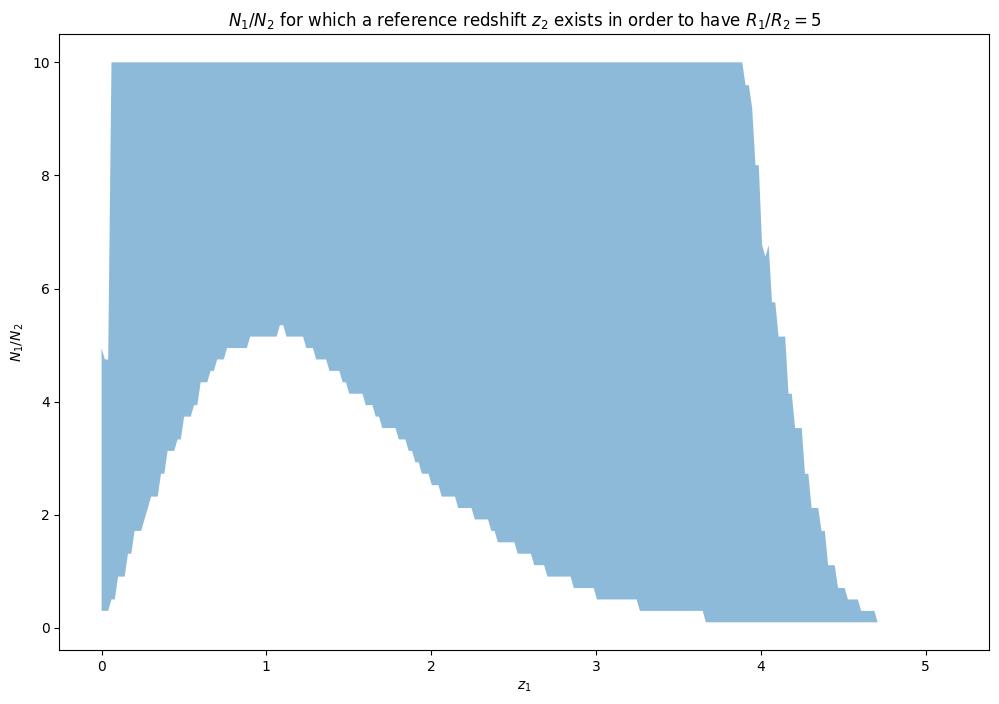

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$N_1 / N_2$ for which a reference redshift $z_2$ exists in order to have $R_1 / R_2 = {0}$'.format(R1_R2_test))

ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$N_1 / N_2$')

for alpha_band in (alpha_sx,):
        alpha_low = []
        alpha_high = []

        for z in alpha_band[:, 2]:
                z_indexes = np.where(alpha_band[:, 2] == z)[0]
                alpha_low.append(np.min(alpha_band[z_indexes, 1]))
                alpha_high.append(np.max(alpha_band[z_indexes, 1]))
        
        alpha_low = np.array(alpha_low)
        alpha_high = np.array(alpha_high)

        sort_mask = np.argsort(alpha_band[:, 2])
        ax.fill_between(alpha_band[:, 2][sort_mask], alpha_low[sort_mask], alpha_high[sort_mask], alpha=0.5)

plt.show()